## Objective:
#### Predict individual health insurance premiums based on demographic and lifestyle features.
#### This is a supervised regression problem where prediction error directly impacts pricing risk.


In [1]:
import warnings
warnings.filterwarnings("ignore")

### IMPORTING REQUIRED LIBRARIES

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

#### IMPORTING DATASET INTO THE DATAFRAME

In [3]:
df = pd.read_excel("premiums.xlsx")

In [4]:
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [5]:
df.shape

(50000, 13)

In [6]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

#### MAKING FEATURE NAMING CONSISTENT

In [7]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [8]:
print(df.duplicated().sum())
df.skew(numeric_only=True)

0


age                      3.124287
number_of_dependants     0.323496
income_lakhs             6.139762
annual_premium_amount    0.517690
dtype: float64

#### DATA CLEANING - HANDLING MISSING VALUES

In [9]:
df.isna().sum()
#NA rows are less and we have abundant data so we will choose to simply drop these rows

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [10]:
df.dropna(inplace = True)

In [11]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [12]:
df.duplicated().sum()
#df.drop_duplicates(inplace = True) #enable if we have duplicates in new dataset when added on same notebook

np.int64(0)

#### DATA CLEANING - EDA

In [13]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [14]:
# The column number_of_dependants has negative value, we'll fix it first

In [15]:
df[df.number_of_dependants<0].shape

(72, 13)

In [16]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [17]:
# Could be an error in scraping script that it input values as negative in number_of_dependants column
# So i decided here not to drop the rows but convert them to absolute values

In [18]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

# DATA CLEANING - TREATING OUTLIERS

In [19]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

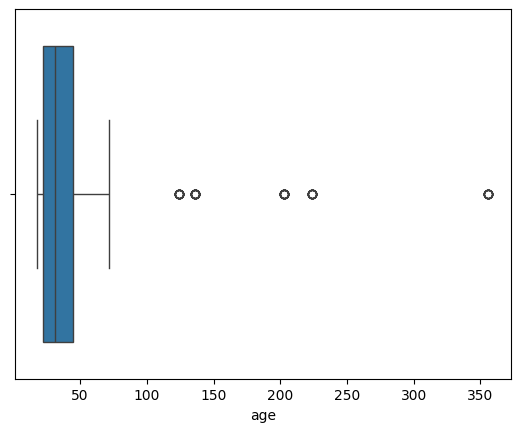

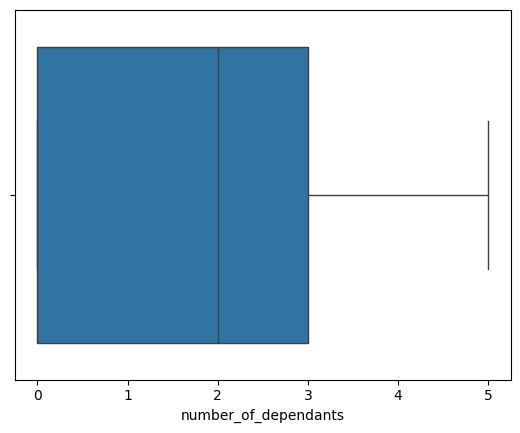

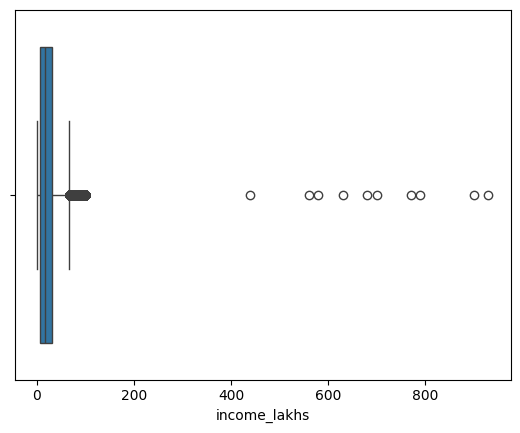

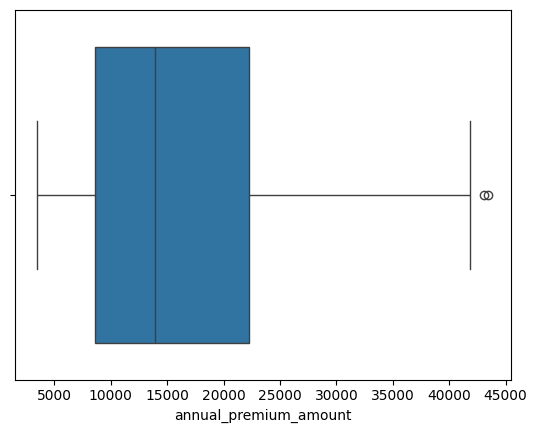

In [20]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

# TREATING 'age' COLUMN

In [21]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [22]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


# TREATING 'income_lakhs' COLUMN

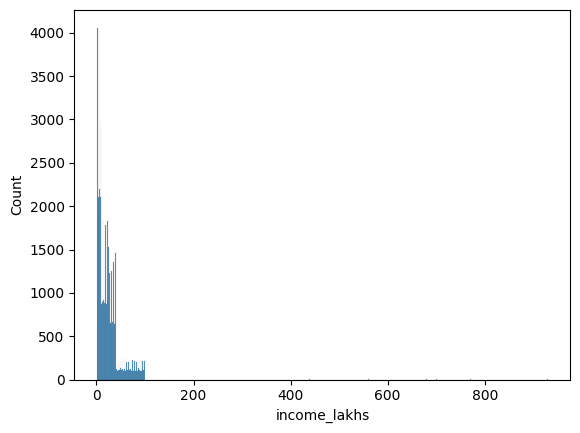

In [23]:
sns.histplot(df1.income_lakhs)
plt.show()

In [24]:
df1.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [25]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [26]:
quantile_threshold_income = df1.income_lakhs.quantile(0.999)
quantile_threshold_income

np.float64(100.0)

In [27]:
df2 = df1[df1.income_lakhs<=quantile_threshold_income].copy()

In [28]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


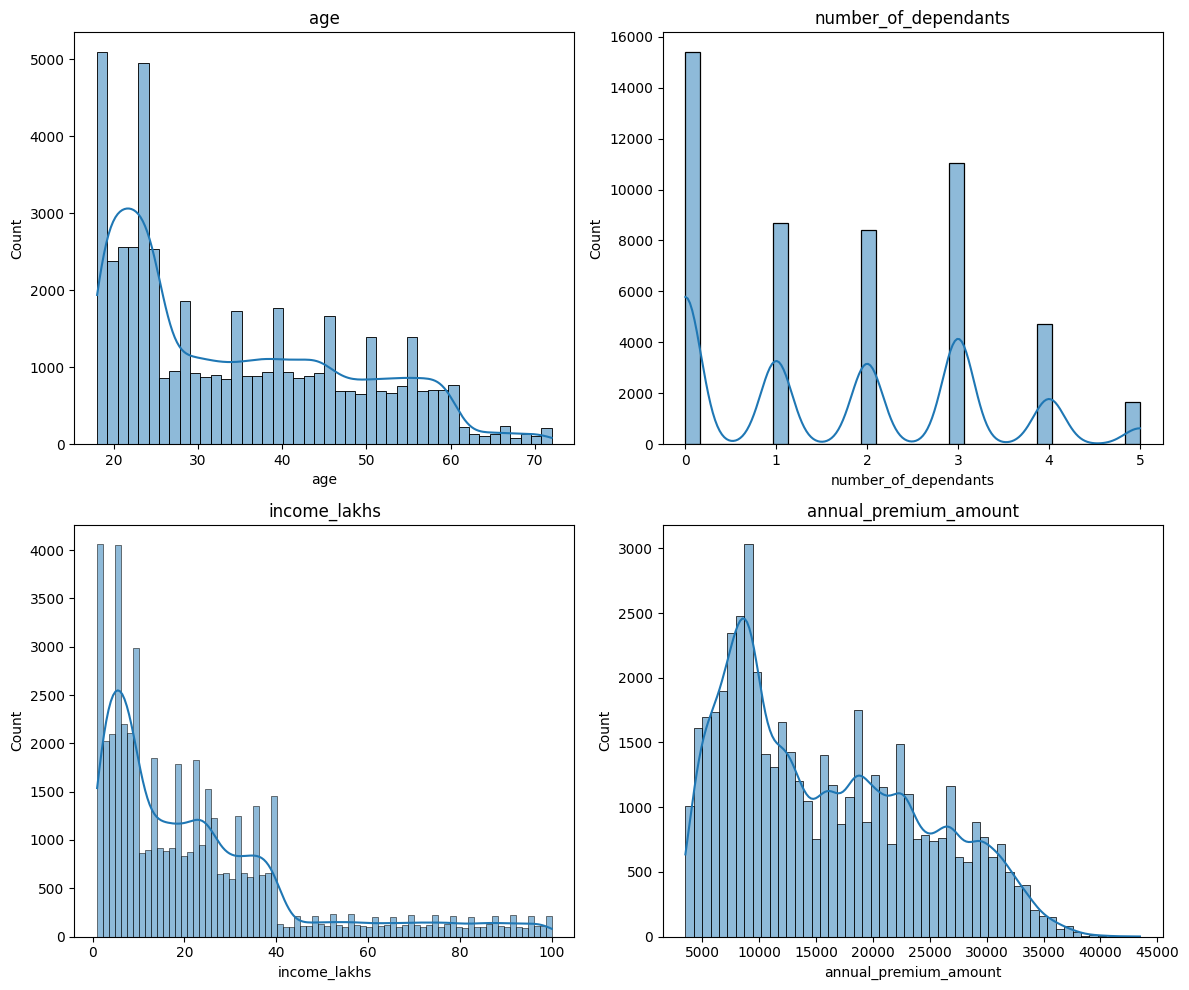

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


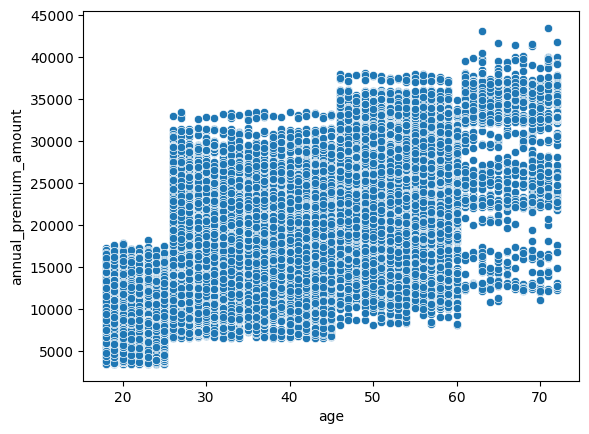

In [30]:
sns.scatterplot(df2, x = 'age', y = 'annual_premium_amount')
plt.show()

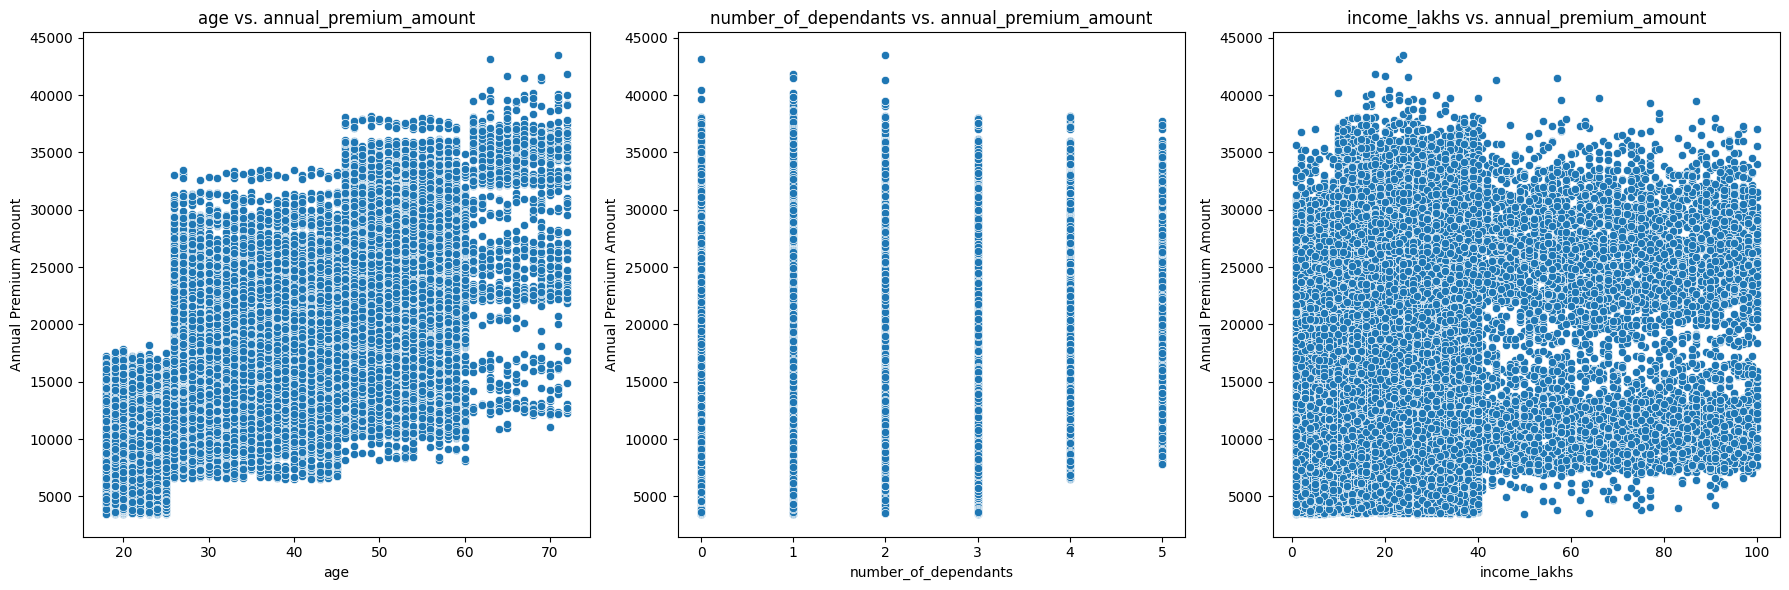

In [31]:
fig, axes = plt.subplots(1, (len(numeric_columns)-1), figsize = (18,6))

for ax, column in zip(axes, numeric_columns):
    sns.scatterplot(x = df2[column], y = df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. annual_premium_amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [32]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [33]:
for col in categorical_columns:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [34]:
df2['smoking_status'].replace({ #here, there were too many redundant types under 'smoking_status' column, so we fixed it
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking' : 'No Smoking'
}, inplace = True)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [35]:
gender_count = df2['gender'].value_counts(normalize = True)
gender_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

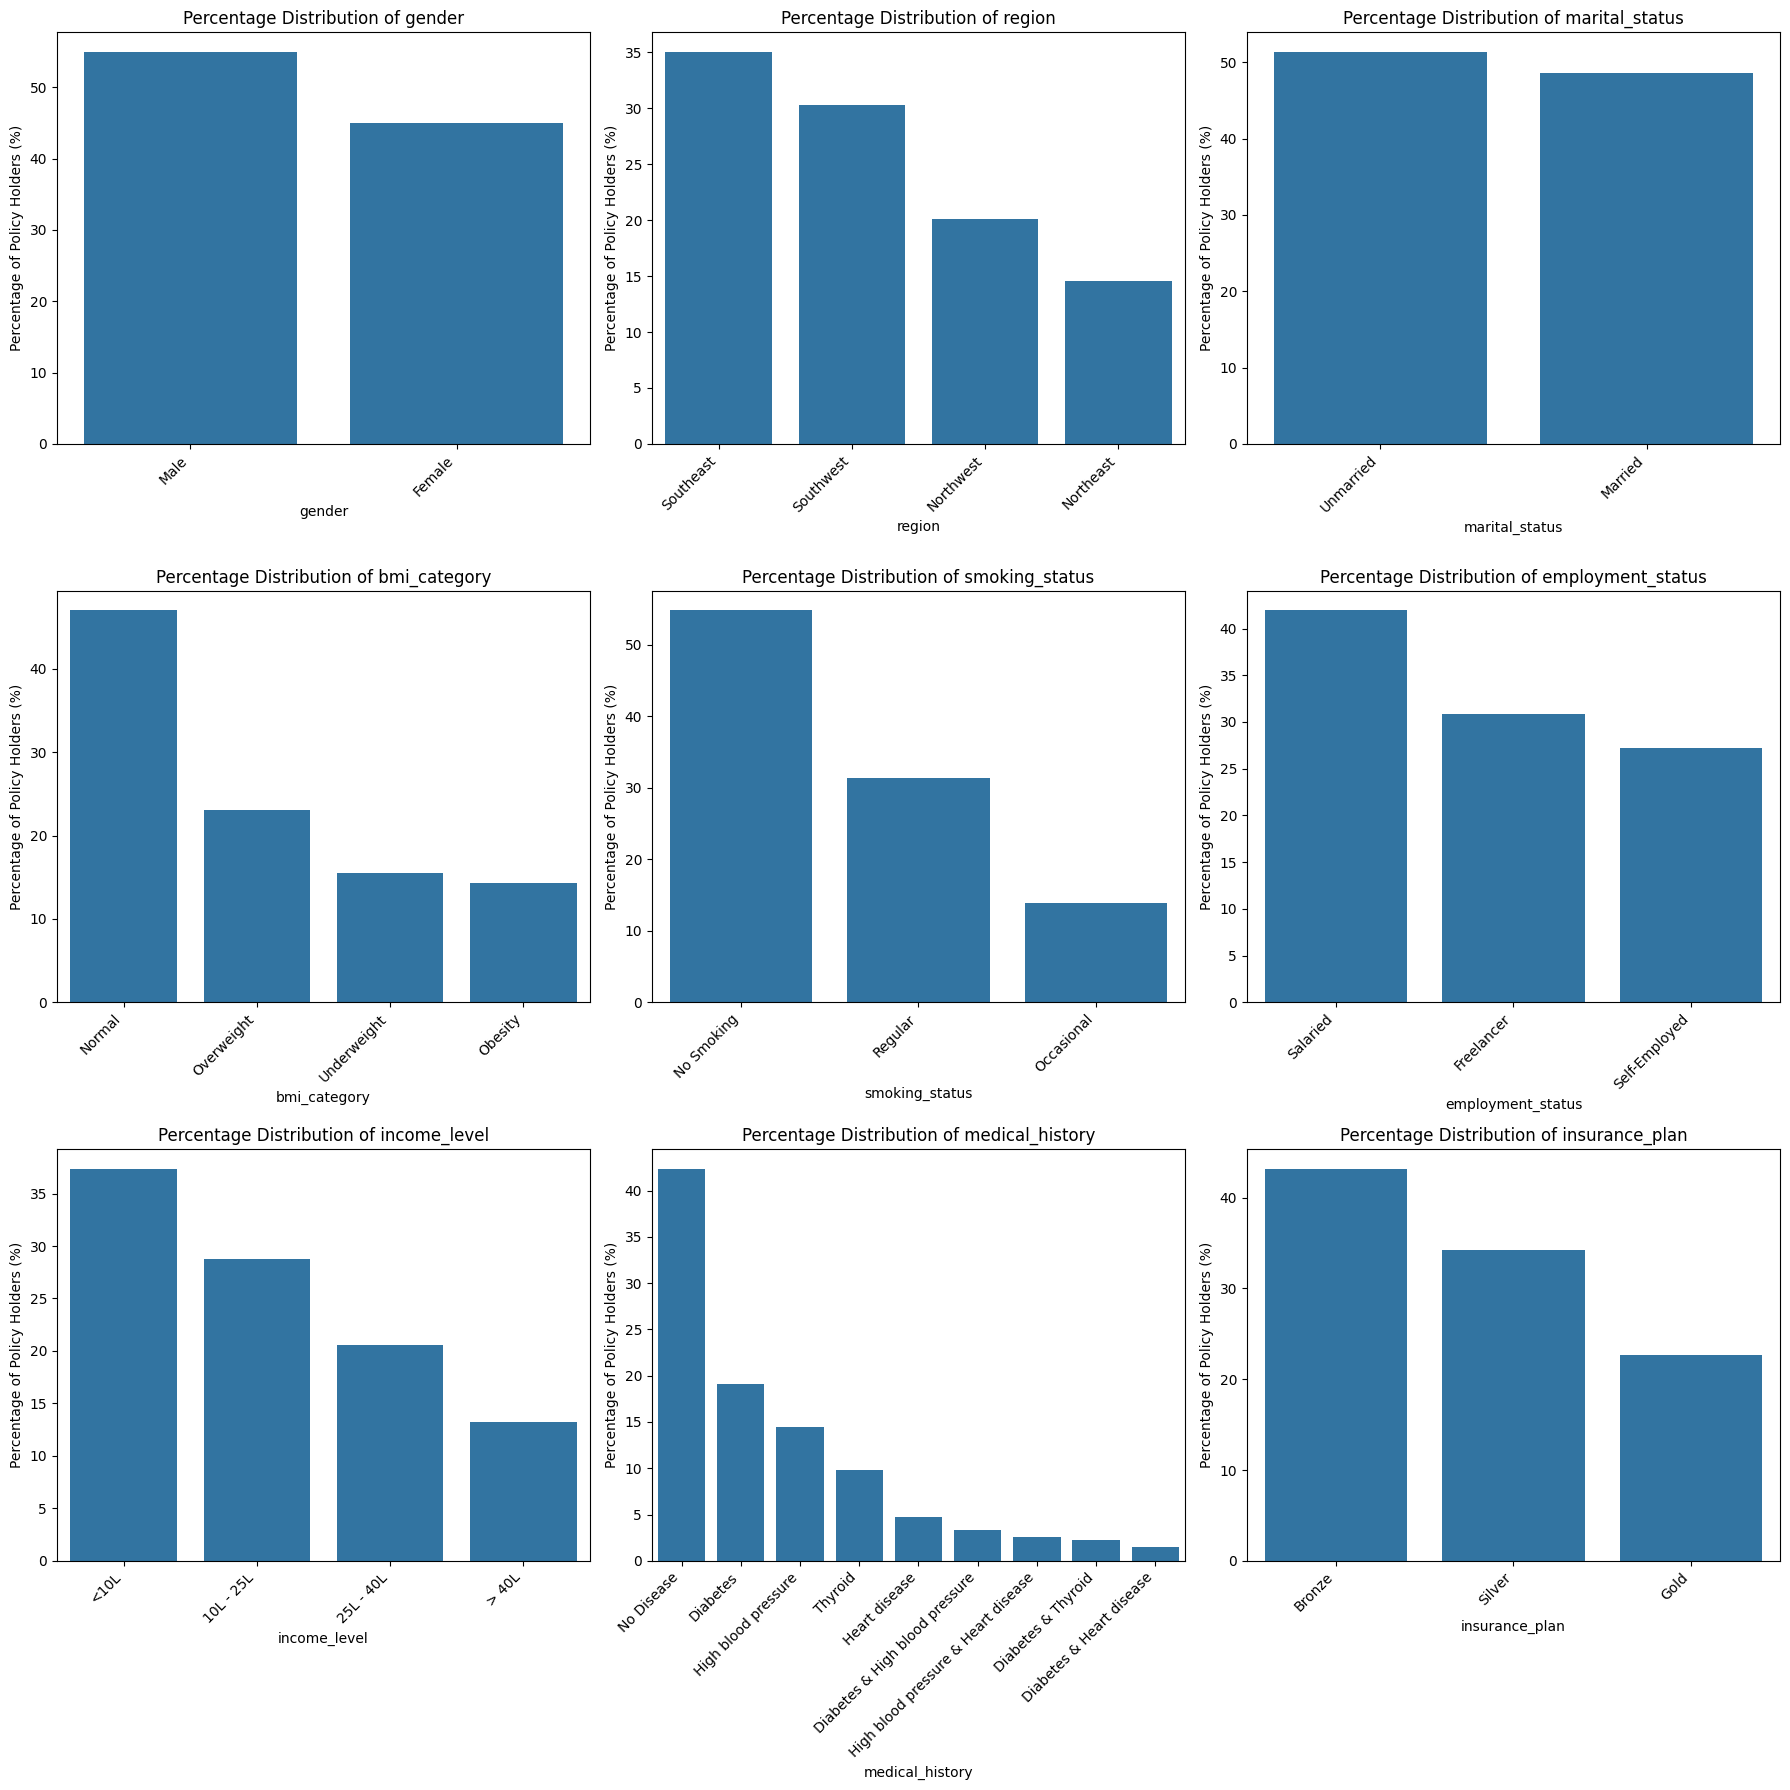

In [36]:
fig, axes = plt.subplots(3,3, figsize = (18,18))
axes = axes.flatten()

for ax, column in zip(axes, categorical_columns):
    category_count = df2[column].value_counts(normalize = True) * 100

    sns.barplot(x = category_count.index, y = category_count.values, ax = ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Percentage of Policy Holders (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


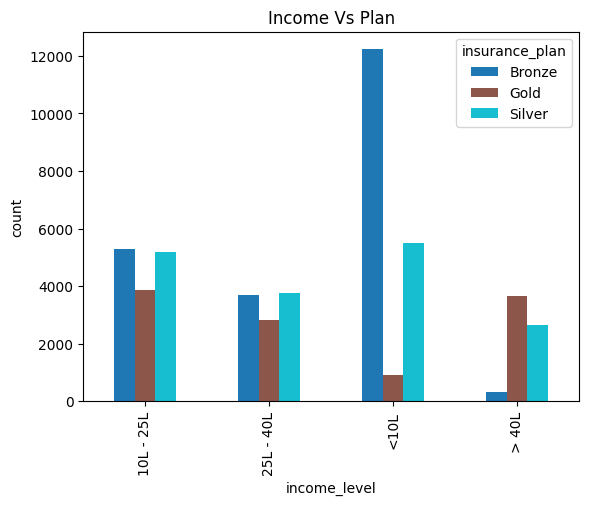

In [37]:
ct1 = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(ct1)

ct1.plot(kind = 'bar', colormap='tab10')
plt.title('Income Vs Plan')
plt.ylabel('count')
plt.show()

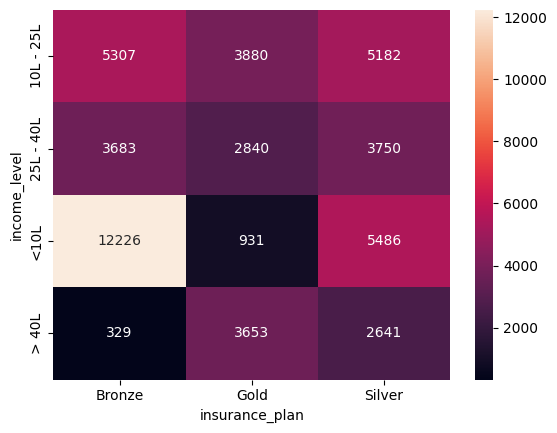

In [38]:
sns.heatmap(ct1, annot = True, fmt = 'd')
plt.show()

# FEATURE ENGINEERING

#### MEDICAL HISTORY AND DISEASE

In [39]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [40]:
# we set some kind of severety value to each disease after *imaginary company discussion, for easier classification
risk_scores = {
    "diabetes" : 6,
    "heart disease" : 8,
    "high blood pressure" : 6,
    "thyroid" : 5,
    "no disease" : 0,
    "none" : 0
}

df2[['disease1', 'disease2']] = df2.medical_history.str.split(" & ", expand = True).apply(lambda  x: x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None


In [41]:
df2['disease1'].fillna('none', inplace = True)
df2['disease2'].fillna('none', inplace = True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score']-min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571


#### INSURANCE PLAN & INCOME LEVEL

In [42]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [43]:
df2['insurance_plan'] = df2['insurance_plan'].map({
    'Bronze' : 1,
    'Silver' : 2,
    'Gold' : 3
})

In [44]:
df2.insurance_plan.unique()

array([1, 2, 3])

In [45]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [46]:
df2['income_level'] = df2['income_level'].map({
    '<10L' : 1,
    '10L - 25L' : 2,
    '> 40L' : 3,
    '25L - 40L' : 4
})

In [47]:
df2.income_level.unique()

array([1, 2, 3, 4])

In [48]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571


## ONE-HOT-ENCODING

In [49]:
nominal_features = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df3 = pd.get_dummies(df2, columns = nominal_features, drop_first = True, dtype = int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1


In [50]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis = 1)
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


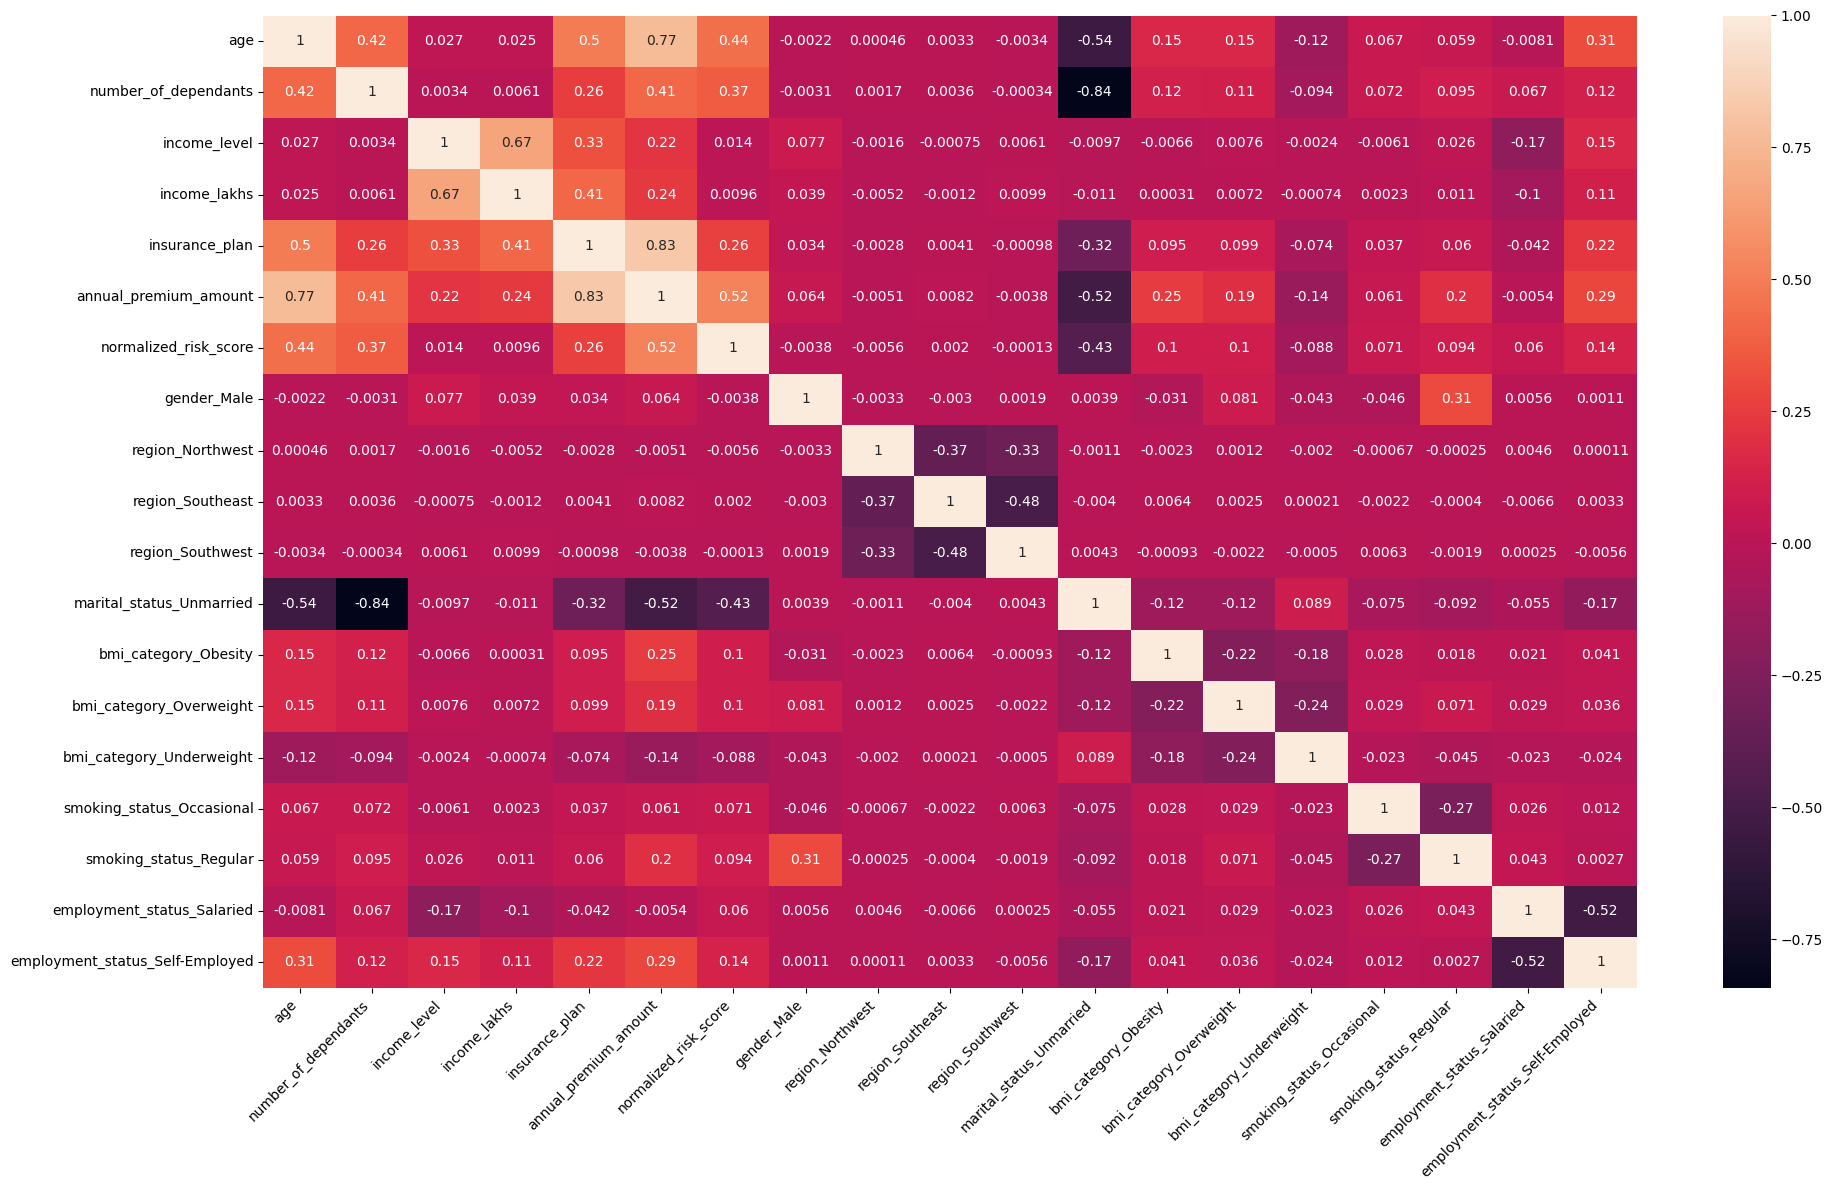

In [51]:
cm = df4.corr()

plt.figure(figsize = (20,12))
sns.heatmap(cm, annot = True)
plt.xticks(rotation = 45, ha = 'right')
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [52]:
X = df4.drop('annual_premium_amount', axis = "columns")
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[to_scale] = scaler.fit_transform(X[to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.666667,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.666667,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [53]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.390278,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.380124,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# all values in X is between 0-1 in every column that means our X is properly scaled

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [55]:
calculate_vif(X)

,column,VIF
0,age,4.546828
1,number_of_dependants,4.552788
2,income_level,3.809392
3,income_lakhs,3.940341
4,insurance_plan,3.470028
5,normalized_risk_score,2.688740
6,gender_Male,2.424683
7,region_Northwest,2.103537
8,region_Southeast,2.923930
9,region_Southwest,2.671921


In [56]:
calculate_vif(X.drop('income_level', axis = 'columns'))

,column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [57]:
X_reduced = X.drop('income_level', axis = 'columns')
X_reduced.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


# MODEL TRAINING & FINE TUNING

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.3, random_state = 10) 

print("X train", X_train.shape)
print('X test', X_test.shape)
print('y train', y_train.shape)
print('y test', y_test.shape)

X train (34935, 17)
X test (14973, 17)
y train (34935,)
y test (14973,)


In [59]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
test_score = lr_model.score(X_test, y_test)
train_score = lr_model.score(X_train, y_train)
train_score, test_score

(0.9282143576916762, 0.9280547230217837)

In [84]:
y_pred_lr = lr_model.predict(X_test) 
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
print('Linear Regressor ==> MSE: ', mse, 'RMSE: ', rmse)

Linear Regressor ==> MSE:  5165611.913027982 RMSE:  2272.798256121291


# X_test.head(1)

In [61]:
feature_weight = lr_model.coef_
feature_weight

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

In [62]:
lr_model.intercept_

np.float64(4824.300272127104)

In [63]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [64]:
coef_df = pd.DataFrame(feature_weight, index = X_test.columns, columns = ['coefficients'])
coef_df = coef_df.sort_values(by = 'coefficients', ascending = True)
coef_df

,coefficients
marital_status_Unmarried,-935.760611
number_of_dependants,-676.443991
income_lakhs,-514.229816
region_Northwest,-35.719292
region_Southwest,-24.652929
region_Southeast,39.965130
employment_status_Salaried,155.984674
gender_Male,168.646662
bmi_category_Underweight,391.171304
employment_status_Self-Employed,415.903973


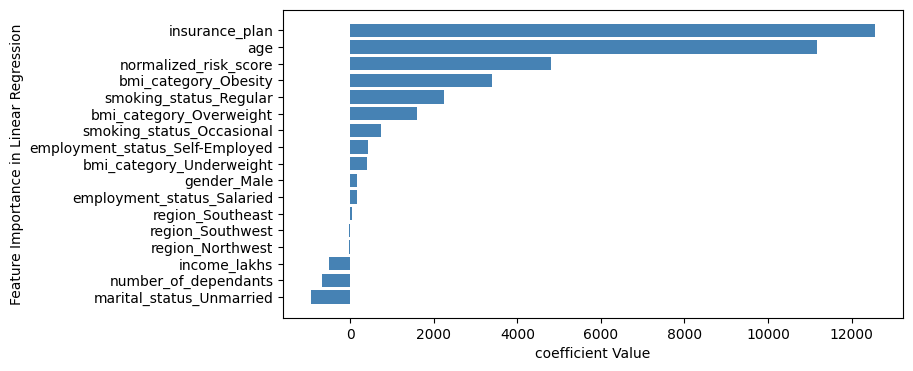

In [65]:
plt.figure(figsize = (8, 4))
plt.barh(coef_df.index, coef_df['coefficients'], color = 'steelblue')
plt.xlabel('coefficient Value')
plt.ylabel('Feature Importance in Linear Regression')
plt.show()

In [66]:
rg_model = Ridge(alpha = 10)
rg_model.fit(X_train, y_train)
test_score_rg = rg_model.score(X_test, y_test)
train_score_rg = rg_model.score(X_train, y_train)
train_score_rg, test_score_rg 
#this doest have much of a difference, so next we'll try XGboost

(0.9282106074563636, 0.9280459054997704)

In [67]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
test_score_xgb = xgb_model.score(X_test, y_test)
train_score_xgb = xgb_model.score(X_train, y_train)
train_score_xgb, test_score_xgb

(0.9860964417457581, 0.9809534549713135)

In [68]:
y_pred_xgb = xgb_model.predict(X_test) 
mse_lr = mean_squared_error(y_test, y_pred_xgb)
rmse_lr = np.sqrt(mse_lr)
print('XGBoost Regressor ==> MSE: ', mse_lr, 'RMSE: ', rmse_lr)

XGBoost Regressor ==> MSE:  1367525.625 RMSE:  1169.4125127601467


In [69]:
param_grid = {
    'n_estimators' : [20, 40, 50],
    'learning_rate' : [0.01, 0.1, 0.2],
    'max_depth' : [3, 4, 5]
}
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter = 10, cv = 3, scoring = 'r2')
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9809474547704061)

In [70]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [71]:
best_model = random_search.best_estimator_

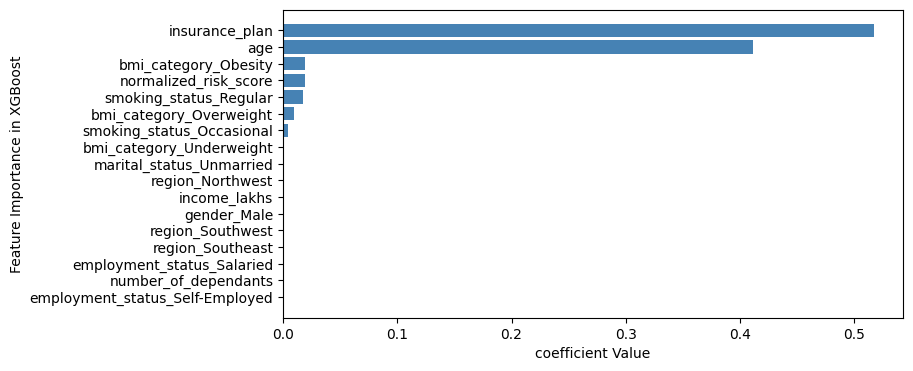

In [72]:
feature_importances = best_model.feature_importances_

coef_df2 = pd.DataFrame(feature_importances, index = X_test.columns, columns = ['coefficients'])
coef_df2 = coef_df2.sort_values(by = 'coefficients', ascending = True)

plt.figure(figsize = (8, 4))
plt.barh(coef_df2.index, coef_df2['coefficients'], color = 'steelblue')
plt.xlabel('coefficient Value')
plt.ylabel('Feature Importance in XGBoost')
plt.show()

### ERROR ANALYSIS

In [73]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_percentage = residuals*100/y_test

results_df = pd.DataFrame({
    'actual' : y_test,
    'predicted' : y_pred,
    'diff' : residuals,
    'diff_in_percent' : residuals_percentage
})
results_df.head()

,actual,predicted,diff,diff_in_percent
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


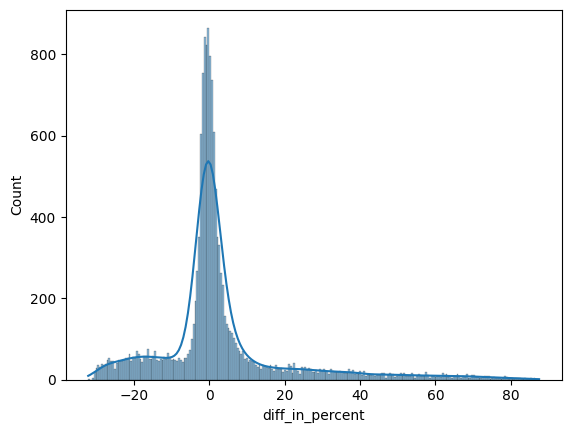

In [74]:
sns.histplot(results_df['diff_in_percent'], kde = True)
plt.show()

In [75]:
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df.diff_in_percent) > extreme_error_threshold]
extreme_results_df.shape

(4487, 4)

In [76]:
results_df.shape

(14973, 4)

In [77]:
extreme_error_in_percent = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_in_percent

29.967274427302478

In [78]:
extreme_results_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [79]:
extreme_error_df = X_test.loc[extreme_results_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


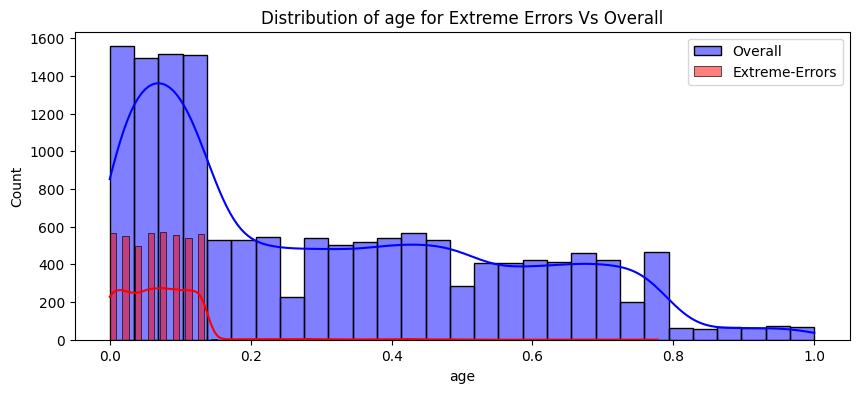

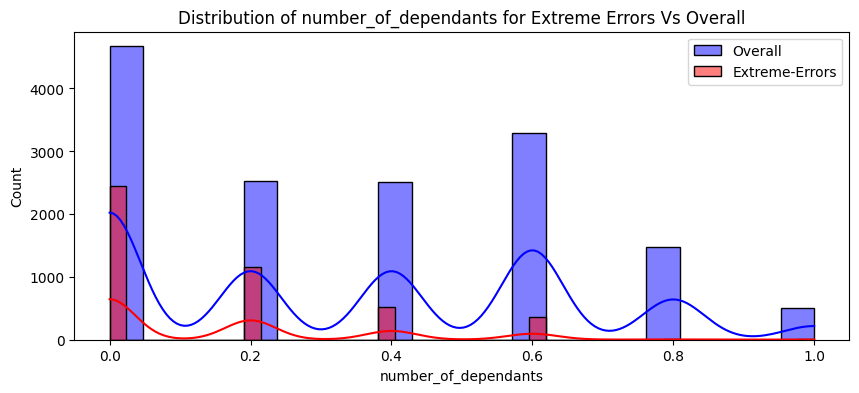

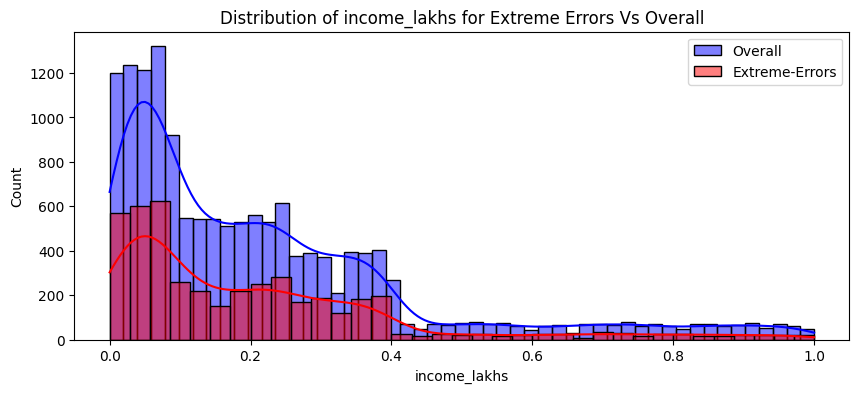

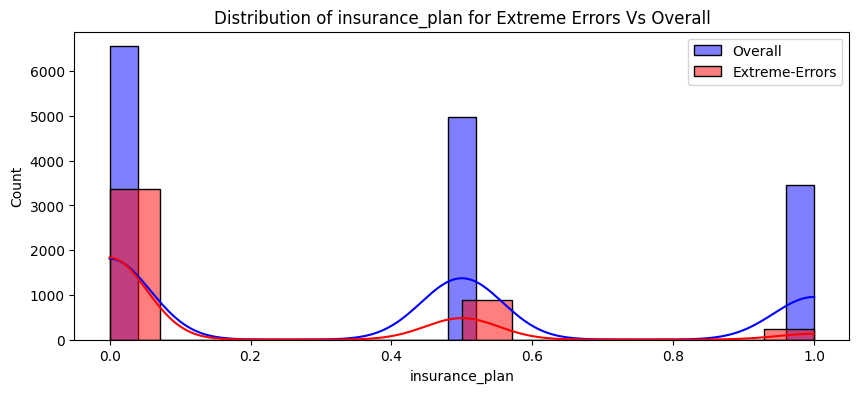

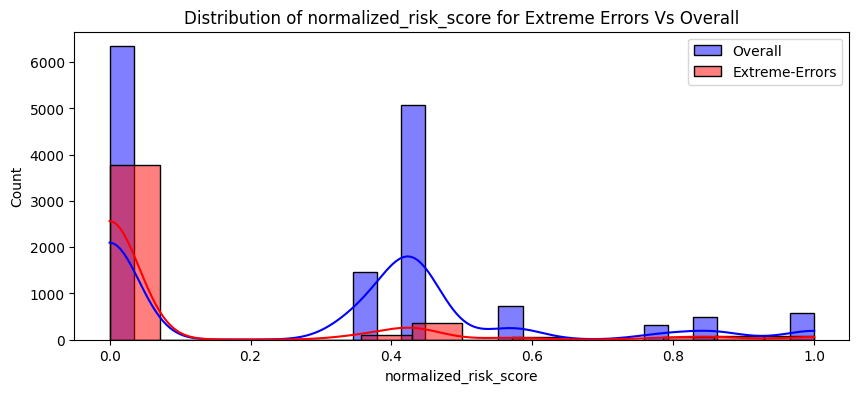

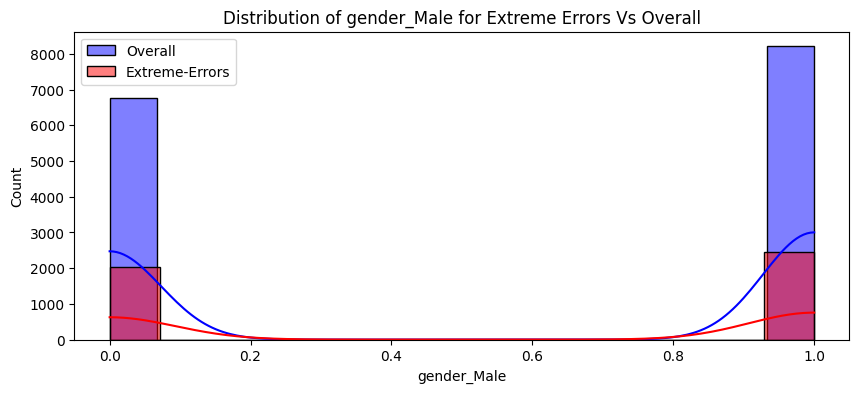

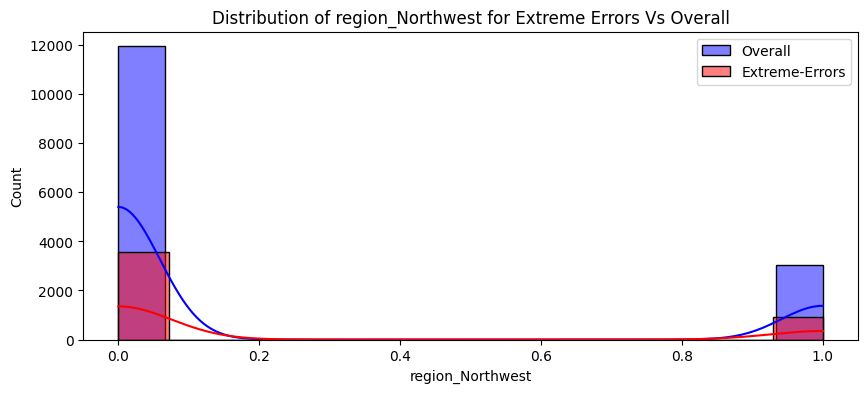

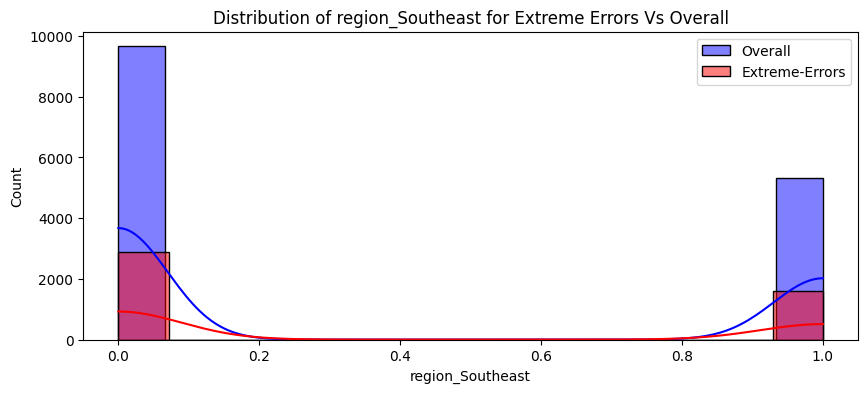

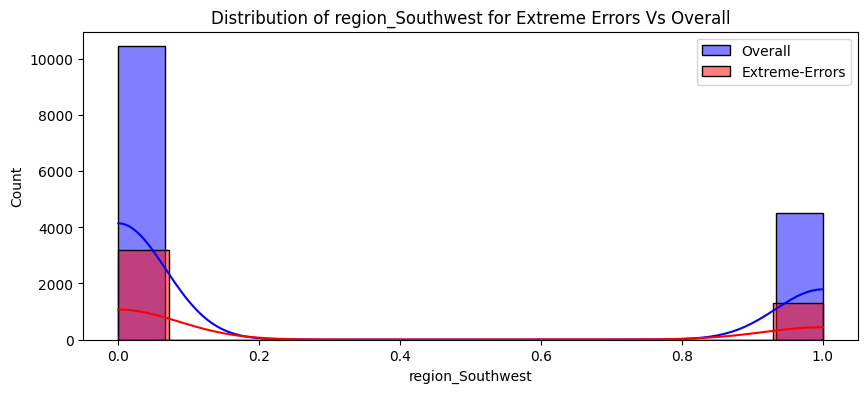

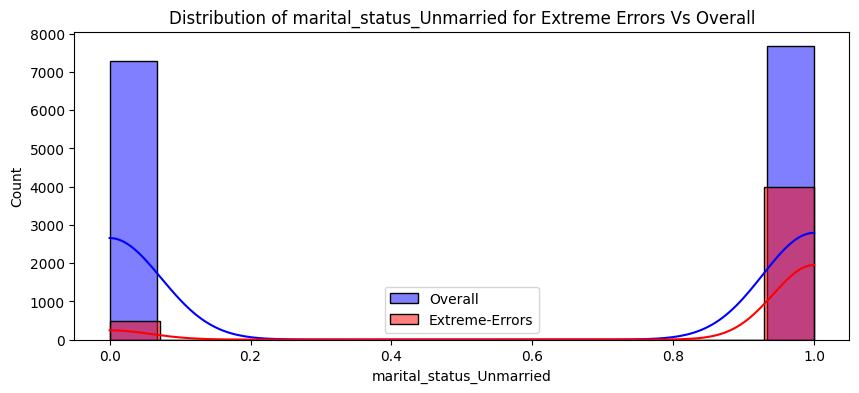

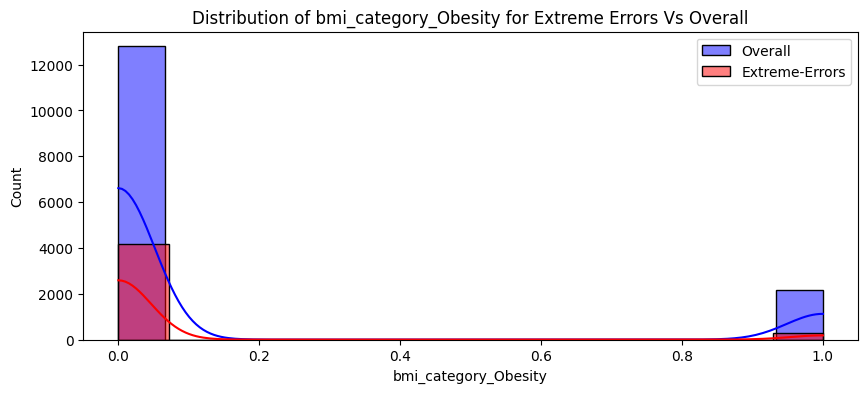

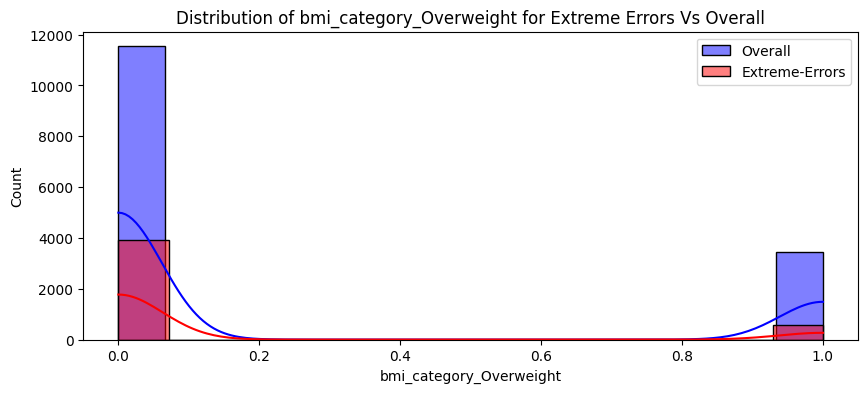

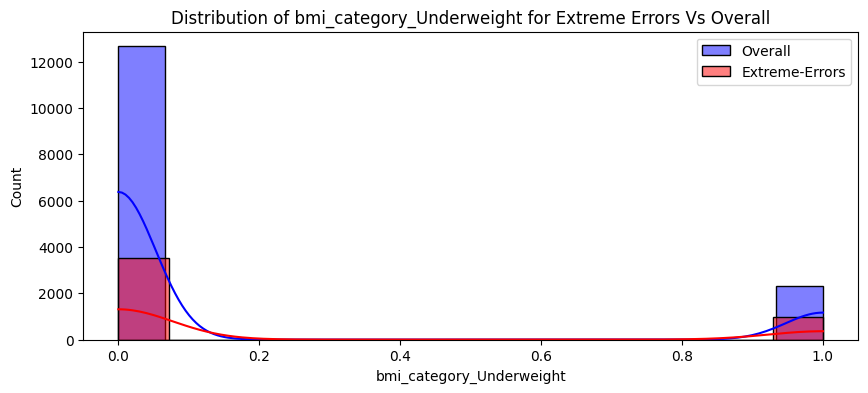

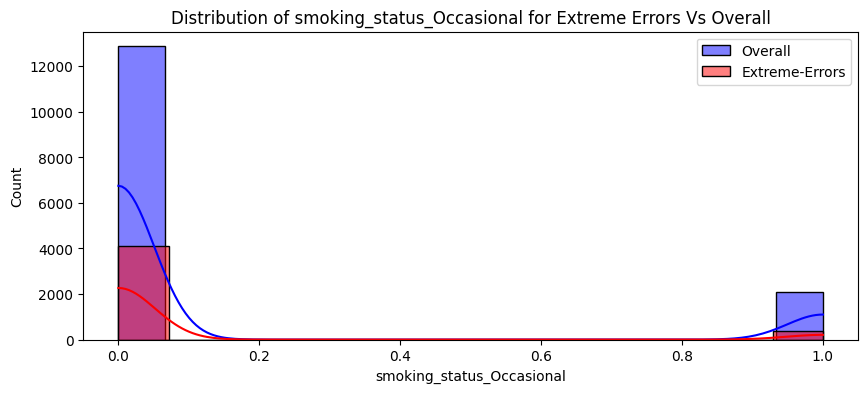

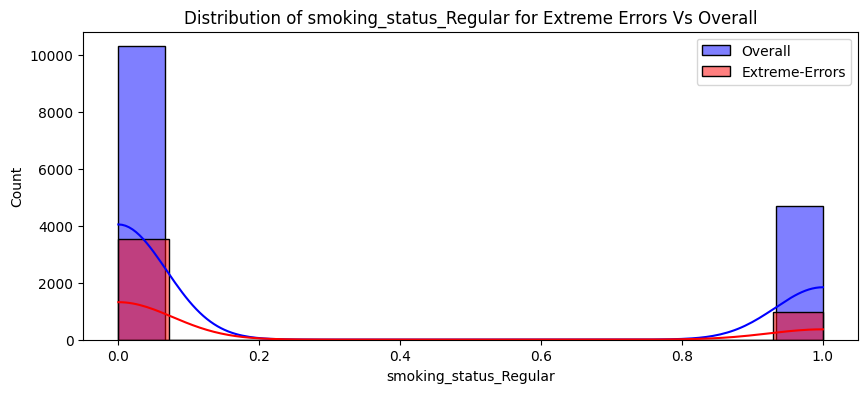

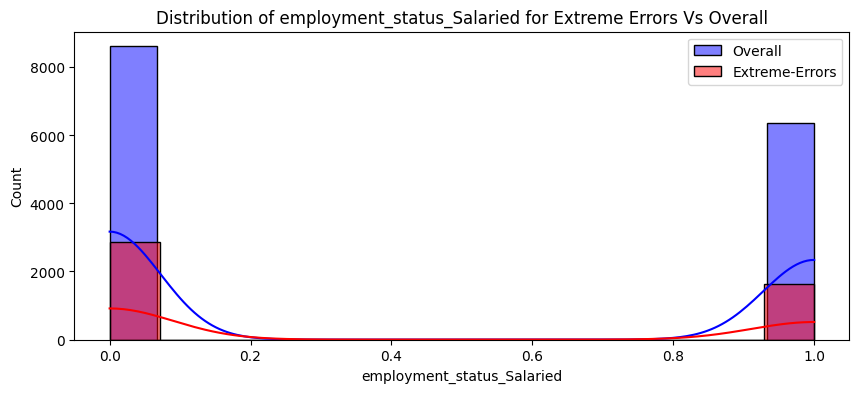

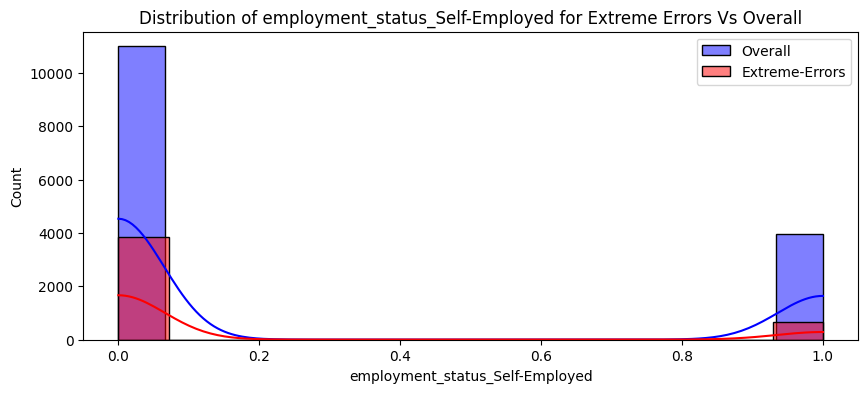

In [80]:
for features in X_test.columns:
    plt.figure(figsize = (10,4))
    sns.histplot(X_test[features], color = 'blue', label = 'Overall', alpha = 0.5, kde = True)
    sns.histplot(extreme_error_df[features], color = 'red', label = 'Extreme-Errors', kde = True)
    plt.legend()
    plt.title(f'Distribution of {features} for Extreme Errors Vs Overall')
    plt.show()

<Axes: xlabel='age', ylabel='Count'>

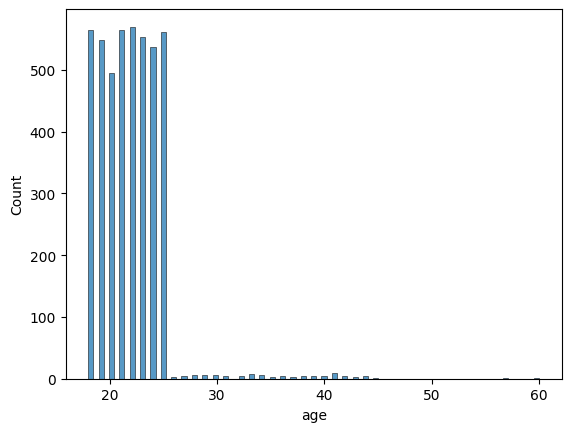

In [81]:
extreme_error_df['income_level'] = -1
df_fixed = pd.DataFrame()
df_fixed[to_scale] = scaler.inverse_transform(extreme_error_df[to_scale])
sns.histplot(df_fixed['age'])